# Linear regression, part 2

In this notebook we expand on the ideas of linear regression as we try to resolve problems we encounter when we try to fit a regression model. More specifically, we talk about how to include categorical data in our model, how to deal with high multi-collinearity between features, and finally what to do if the response variable is binary. Although these topics are not necessarily related to each other, they are all good examples of how we can extend the ideas behind linear regression to address its shortcomings.

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib
matplotlib.rcParams['figure.figsize'] = [10, 7]
import scipy.stats as stats
import matplotlib.pyplot as plt
import statsmodels.api as statsmodels
import statsmodels.formula.api as sm
import patsy as p

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

## Encoding categorical features

It's time to talk about what to do with categorical features. Recall that after expressing the math of linear regression using linear algebra, $\pmb{X}$ ends up being a matrix with a column of 1s as its first column to account for the intercept. So we need to encode our categorical features as numeric columns that we can include in $\pmb{X}$. It turns out that we have more than one option, although most of the time we get go with the default option. Let's read in our data and learn by example:

In [ ]:
hsb2 = pd.read_csv('data/hsb2-2.csv')
hsb2.head()

### Exercise

Notice that we have a few categorical features we can use in the data, however in this case the categorical features are already encoded as numbers. For example `schtype == 1` means "public" and `schtype == 0` means "private". So what's stopping us from using these as is?

- Using `sm.ols` train a model to predict writing score using reading score and socio-economic status (column named `ses`). Then examine the results by calling the fitted model's `summary2()` method.

In [ ]:
ols_model = sm.ols(formula = 'write ~ read + ses', data = hsb2)
ols_model = ols_model.fit()
ols_model.summary2()

- Is the coefficient for `ses` significant? Write your best interpretation of it based on what we learned so far. Do you see any problems with the interpretation?

To encode a variable as categorical we wrap its name with a `C` function in the formula, e.g. `y ~ x + C(v)` if `v` is categorical. 

- Fit a new model this time encoding `ses` as categorical. What changes in the results table? Write the prediction equation.

In [ ]:
ols_model = sm.ols(formula = 'write ~ read + C(ses)', data = hsb2)
ols_model = ols_model.fit()
ols_model.summary2()

When we encode a variable as categorical, by default it creates a separate coefficient for all its categories except the first one. The first category becomes what we call **the baseline**, and the coefficients for each of the other categories capture the average "effect" of moving from the baseline to that category. So in the results above we can see that the coefficient for `C(ses)[T.2]` is -0.4746. This means that on average students with `ses == 2` have a score of 0.4746 less than the `ses == 1` (baseline) students. For an **orginal** categorical column like `ses`, both ways of fitting the model are valid, although the first way is more constrained. For **nominal** categorical columns like `race` or `gender`, only the second way is valid.

So let's recode the `ses` column using proper names: low, middle and high:

In [ ]:
hsb2['ses'] = hsb2['ses'].replace({1: 'low', 2: 'middle', 3: 'high'})
hsb2['ses'].value_counts(sort = False)

Notice that now the first category is `high`, whereas before it was `1` (which corresponds to `low`). This is because when we alphabetically sort the catogories by their new names, `high` appears first, whereas before `1` appeared first.

- Refit the same model now that `ses` has been recoded. What differences do you see?

In [ ]:
ols_model = sm.ols(formula = 'write ~ read + C(ses)', data = hsb2)
ols_model = ols_model.fit()
ols_model.summary2()

Foretunately, there's an easy way to choose which category to use as the **baseline**.

- Refit the same model, but use this as `formula = "write ~ read + C(ses, Treatment(reference = 'low'))"`. Do the results make sense?

In [ ]:
ols_model = sm.ols(formula = "write ~ read + C(ses, Treatment(reference = 'low'))", data = hsb2)
ols_model = ols_model.fit()
ols_model.summary2()

The type of coding shown above is called **dummy coding** (because it's what we get if we encode each category except the baseline using **dummy variables**). This is the most common type of encoding and the default one used by most statistical packages for regression models (linear regression, ANOVA, logistic regression, etc.). In machine learning, **dummy coding** is more commonly known as **one-hot encoding**, however in the latter case we usually do not drop any of the columns. Not dropping the baseline column can cause issues with convergence of the regression model, but this is only caused if there's no regularization, so in practice one-hot encoding the feature is fine.

In [ ]:
data = hsb2.loc[~hsb2.duplicated(subset = 'ses'), :].sort_values(['ses'])
p.dmatrix("C(ses, Treatment('low'))", data, return_type = "dataframe")

There are other coding schemes that we can use (more on this topic [here](https://patsy.readthedocs.io/en/latest/API-reference.html#patsy.Treatment). Here's another one called deviation coding for example:

In [ ]:
p.dmatrix("C(ses, Sum)", data, return_type = "dataframe")

- Rerun the same model, but this time use deviation coding instead of dummy coding. What changes in the model summary? 

In [ ]:
ols_model = sm.ols(formula = "write ~ read + C(ses, Sum)", data = hsb2)
ols_model = ols_model.fit()
ols_model.summary2()

- Create a scatter plot of reading score (x-axis) vs writing score (y-axis). Then add a line plot of the prediction line for writing score (you will need to use your model to get predictions and add them as a new column to the data). Color-code the line plot by `hue = 'ses'` se we get a separate line plot for each value of `ses`.

In [ ]:
hsb2['write_pred'] = ols_model.predict(hsb2)

In [ ]:
sns.scatterplot(x = 'read', y = 'write', data = hsb2)
sns.lineplot(x = 'read', y = 'write_pred', hue = 'ses', data = hsb2);

- Fit a new model now that also includes the interaction between `read` and `C(ses)`. Examine the model summary and report what changed. Then recreate the scatter plot with the prediction lines above. What looks different now? Can you interpret each of the coefficients based on the line plots?

In [ ]:
ols_model = sm.ols(formula = "write ~ read * C(ses, Sum) + read:C(ses)", data = hsb2)
ols_model = ols_model.fit()
hsb2['write_pred_w_interactions'] = ols_model.predict(hsb2)
ols_model.summary2()

sns.scatterplot(x = 'read', y = 'write', data = hsb2)
sns.lineplot(x = 'read', y = 'write_pred_w_interactions', hue = 'ses', data = hsb2);

And voila! This was a long exercise but the goal was to slowly build our way up. There are other things we can test. For example, how does changing the encoding change the prediction? The answer is that it doesn't. Changing the encoding changes the coefficients and their interpretation, but those new coefficients still return the same prediction. What about including more than one categorical feature? What about the interaction of two categorical features? We leave it to you to try this and based on what you learned in this exercise you should be able to make a good guess as to what to expect.

### End of exercise

As you saw in the example above, when we have categorical features in a model, we have some flexibility in how we want them encoded, but the general idea is to have a separate coefficient for each **level** (grouping) of a categorical feature, and another coefficent for each combination of the interactions of two categorical features (assuming we fit a model with interactions). Different choices for the **encoding** of the categorical features leads to different interpretations of their coefficients, but ultimately all lead to the same prediction. You can imagine that having **high-cardinality** categorical features can cause the model to quickly grow in complexity (number of coefficients), even when no interactions are being considered. In such cases, one option is to use **feature hashing**, which allows us to trade-off the size of the encoding with the risk of collision.

## Principal component regression

Imagine we are performing linear regression on $p$ features, where our model is as follows:

$$Y = \beta_{0} + \beta_1X_1 + ... + \beta_pX_p + \text{error}$$

So far for the linear models we fit, we took it for granted that the features are given to us, although we saw how we can apply transformations to one feature at a time, such as replacing $X$ with $\log(X)$ or $X^2$. We also learned that having a lot of correlated features can introduce the problem of **multi-collinearity** which can make the predictions unstable (high variance). So let's now consider a transformation that will help in such a situation. Unlike previous transformation that only applied to one feature at a time, this new transformation takes as input **all** $p$ features and returns as its output a set of $p$ new features, although we usually only take the top $k$ where $k < p$. For this reason, PCA is an example of **dimensionality reduction**.

$$
\begin{align}
Y &= \beta_{0} + \beta_1f_1(X_1, \cdots, X_p) + \cdots + \beta_pf_p(X_1, \cdots, X_p) + \text{error} \\
  &\approx \beta_{0} + \beta_1f_1(X_1, \cdots, X_p) + \cdots + \beta_kf_k(X_1, \cdots, X_p) + \text{error}
\end{align}
$$

Unlike the old features, the new features $f_1, \cdots, f_p$ are completely un-correlated to each other by design, as we will see, so we can fit a linear regression model without worrying about **multi-collinearity**. What does $f_i(X_1, \cdots, X_p)$ look like? The answer is that each $f_i()$ is a **linear combination** of the original features $X_1, \cdots, X_p$:

$$f_i = b_{i,0} + b_{i,1} X_1 + \cdots + b_{i,p} X_p$$

The question still remains, how do we find such magical $f_i$ functions that assures us that the new features, $f_i$ taken together are 100% independent of each other? Notice that we are referring to $f_i$ both as a function and as a feature. It would be more correct to say call the output of $f_i$ a feature, but from context it is usually clear if we mean $f_i$ the function or $f_i$ the feature.

The method of finding these very important components is called **principal component analysis** or PCA. PCA is an **unsupervised learning** algorithm that takes $X_1, \cdots, X_p$ as inputs and returns $f_1, \cdots, f_p$ as output. We call $f_1, \cdots, f_p$ the **principal components**. We need to normalize the data prior to performing PCA.

After performing PCA, we can then use the top $k$ principal components as features for a linear regression model with $Y$ as target. In other words, we are using PCA (unsupervised learning) to create features that we then use to train a linear regression algorthim (supervised learning). This is why we refer to this technique as **principal component regression**.

Time to see this in action. Here's a scatter plot of two normalized features `X_1` and `X_2`. Note that we only have features, no target!

In [ ]:
np.random.seed(10)

X = np.dot(np.random.randn(100, 2), np.random.rand(2, 2))
X = StandardScaler().fit_transform(X) # normalize the data

sns.scatterplot(X[:, 0], X[:, 1]);

Let's look at the two principal components that result from running PCA on the data.

In [ ]:
pca = PCA(n_components = 2)
pca.fit(X)
pca_df = pd.DataFrame(data = pca.transform(X), columns = ['pc1', 'pc2'])

print(pca_df.shape)
pca_df.head()

And are the principal components plotted against each other.

In [ ]:
sns.scatterplot('pc1', 'pc2', data = pca_df);

Here's how we interpret the principal components: 

1. The first principal component is a linear combination of $X_1$ and $X_2$ in the direction where the data has the most variation. You can see that in the above scatter plot by how the first principal component has a wider range of values than the second one.
1. The second principal component is another linear combination of $X_1$ and $X_2$ in the direction that has the most variation while being perpendicular to the first one. We can see that in the above scatter plot by how the second principal component looks uncorrelated to the first one.

This argument can be extended to higher dimensions. So in $p$ dimensions we have $p$ principal components.

Here are the two principal components and the amount of variation they each capture. Note that in this context, variation is like information. The more variation we capture, the more information we have.

In [ ]:
exp_var = pca.explained_variance_
components = pca.components_

print("Variance explained by each PC: {}".format(exp_var))
print("Principal components: \n{}".format(components))

v1 = 2 * components[0] * np.sqrt(exp_var[0])
v2 = 2 * components[1] * np.sqrt(exp_var[1])
c = (0, 0) # center is at 0, 0 because of our standardization

sns.scatterplot(X[:, 0], X[:, 1], alpha = 0.5)
plt.annotate('', c + v1, c, arrowprops = {'arrowstyle': '->', 'shrinkA': 0, 'shrinkB': 0, 'linewidth': 3})
plt.annotate('', c + v2, c, arrowprops = {'arrowstyle': '->', 'shrinkA': 0, 'shrinkB': 0, 'linewidth': 3})
plt.axis('equal')
plt.grid()

How do we interpret the above variances and components? We can think of the principal components as performing a rotation of the axes, and the variance explained as how much we stretch each axis so that we express the original data in terms of the new axes.

Once we have the principal components, we can then transform each data point by performing a simple matrix multiplication. The result is the same as what we obtained by calling `pca.transform` earlier.

In [ ]:
np.matmul(X, pca.components_)[:5, :]

In linear algebra terms, we describe this as a **change of bases**: Our data expresses each point in terms of the coordinates $X_1$ and $X_2$. While those coordinates are perpendicular to each other, the data we have suggests that they share a lot of variation. PCA changes our coordinates to use the axes spanned by the principal components, and expresses the data points in terms of these new bases. The new coordinates align themselves with the data more naturally. This is why PCA is related to the idea **singular value decomposition (SVD)** in linear algebra, but we leave it to the reader to learn this in more depth.

### Exercise

Let's try our hand at **principal compenent regression**. This means we are first going to use **principal component analysis** to create a new set of features and then use those features to train a linear regression model.

We are going to use the HSB2 data set from earlier.

In [ ]:
hsb2 = pd.read_csv('data/hsb2-2.csv')
hsb2.head()

In [ ]:
hsb2['ses'].value_counts()

- Train a linear regression model to predict a student's math score using reading, writing and science scores. Decide if you should train the model with main effects only, or include two-way interactions as well.

In [ ]:
# ols_model = sm.ols(formula = "math ~ read * write * science", data = hsb2) <- the interaction terms here lead to SUPER HIGH P values... 
ols_model = sm.ols(formula = "math ~ read + write + science", data = hsb2)
ols_model = ols_model.fit()
hsb2['math_pred'] = ols_model.predict(hsb2)
ols_model.summary2()

In [ ]:
sns.scatterplot(x = 'read', y = 'math', data = hsb2)
sns.lineplot(x = 'read', y = 'math_pred', hue = 'ses', data = hsb2);

- Examine the data to see if you should be worried about multi-collinearity.

In [ ]:
# do a pairs plot to see if there's a relationship between reading / writing / science
pair_cols = ['read', 'write', 'science']
sns.pairplot(hsb2[pair_cols]);

# yep... multi-collinearity.

- Apply PCA to the features and extract the principal components. How correlated are the principal component with the original features? You can start with the code below:

In [ ]:
features_orig = ['read', 'write', 'science']
features_pca = ['pc_' + str(i+1) for i in range(len(features_orig))]
pca = PCA(n_components = 3)

pca.fit(hsb2[features_orig])
pca_features = pd.DataFrame(data = pca.transform(hsb2[features_orig]), columns=features_pca)

In [ ]:
features = np.concatenate([hsb2[features_orig], pca_features], axis = 1)
hsb2_new = pd.DataFrame(features, columns=features_orig + features_pca)
hsb2_new['math'] = hsb2['math']

In [ ]:
## perform PCA and get the components
features = np.concatenate([hsb2[features_orig], pca_features], axis = 1)
hsb2_new = pd.DataFrame(features, columns = features_orig + features_pca)
hsb2_new['math'] = hsb2['math']

## examine the correlation between original features and PCs
## HINT: look at a heatmap of the correlation matrix, and let cmap = 'RdBu'

- Did you remember to normalize the data first?

- Train a linear regression model to predict math score, but this time use the principal components as features. How many principal components would you include? Compare the model performance to the previous one. It may help to look at the following bar plot.

In [ ]:
sns.heatmap(hsb2_new.corr(), cmap = 'RdBu')

In [ ]:
sns.barplot(features_pca, pca.explained_variance_, color = 'grey');

In [ ]:
ols_model = sm.ols(formula= "math ~ pc_1", data = hsb2_new).fit()
print(ols_model.summary2())

# the R squared of the PCA regression is the same a the traditional regression...
# this suggests that we're not losing any predictive ability by using this dimensional reduction technique.

- Interpret your model's coefficents. Would you prefer the model with PCA or without?

In [ ]:
# You can't really intrepret this coefficient, as it's a dimensional reduction of the other 3 terms.

As you can imagine, interpreting coefficients becomes much more challenging once we perform feature engineering steps like PCA was here. This trade-off between interpretability and model accuracy is another manifestation of the **bias variance trade-off**.

### End of exercise

## Logistic Regression

Until now, we have been working strictly with linear **regression models**, which assumes that we have a numeric target. With a slight modification of linear regression, we can also predict binary targets (`{False, True}` or `{0, 1}` etc.). The result is called **logistic regression**. As mentioned earlier, the word "regression" in logistic regression refers to its relationship to linear regression, but logistic regression is a classification algorithm.

The response of the linear model is transformed to the log likelihood using a sigmoidal function, also known as the **logistic map** or the **sogmoid function**:

$$f(x | x_0, \kappa) = \frac{1}{1 + e^{-\kappa(x - x_0)}}$$

where $\kappa$ is a measure of the steepness of the curve, as you can see here:

In [ ]:
# Plot the logistic transformation function (f(x) above)
x_seq = np.linspace(-7, 7, 100)

def log_fun(x, center = 0, scale = 1):
    e = np.exp(-scale*(x - center))
    log_out = 1./(1. + e)
    return log_out

log_fun_vectorized = np.vectorize(log_fun)

for ii in range(10):
    log_y = log_fun_vectorized(x_seq, scale = ii)
    sns.lineplot(x_seq, log_y, alpha = 1.0/(ii + 1), color = 'blue');
    
plt.xlabel('x')
plt.ylabel('logistic(x)');
plt.legend(['kappa = ' + str(ii) for ii in range(10)]);

Let's make this a bit more concrete with a simple example. Say we have a linear model:

$$\hat{Y} = b_0 + b_1 X$$

Now, depending on the value of $\hat{Y}$ we want to classify the output from a logistic regression model as either `0` or `1`. We can use the linear model in the logistic function as follows:

$$f(\hat Y|X) = f(b_0 + b_1 X) = \frac{1}{1 + e^{-\kappa(b_0 + b_1 X)}}$$

We can ignore $\kappa$ since it can be factored into the coefficients. In this way we transform the continuous output of the linear model defined on $-\infty \le \hat Y \le \infty$ to a binary response, $0 < f(\hat Y|X) < 1$. If we do the transformation in reverse we get

$$e^{-(b_0 + b_1 X)} = \frac{1}{f(\hat Y|X)} - 1 = \frac{1 - f(\hat Y|X)}{f(\hat Y|X)} \quad\Rightarrow\quad b_0 + b_1 X = \log(\frac{f(\hat Y|X)}{1 - f(\hat Y|X)})$$

The right-hand side shows the relationship between linear and logistic regression: Logistic regression is what we get if we have a binary response variable and run linear regression, not to predict $Y$ directly, but to predict a transformation of $Y$.

What about interpreting our results? First note that because of the nature of the logistic map, we can think of $f(\hat Y|X)$ as a probability: $f(\hat Y|X) = P(Y = 1|X)$. This means we can rewrite the right-hand side of the above equation as 

$$b_0 + b_1 X = \log(\frac{f(\hat Y|X)}{1 - f(\hat Y|X)}) = \log(\frac{P(Y = 1|X)}{P(Y = 0|X)})$$

We call the ratio $P(Y = 1) / P(Y = 0)$ the **odds ratio**, and so the quantity on the right-hand side of the above equation is called the **log odds-ratio**.

To summarize, when we have a binary response variable $Y \in \{0, 1\}$, logistic regression fits a linear regression model to predict the log odds-ratio of $Y = 1$ using our features. Once we have the prediction, we can express it as a probability $P(Y = 1 | X)$ by rewriting it:

$$P(Y = 1|X) = \frac{1}{1 + e^{-(b_0 + b_1 X)}}$$

We can easily extend this idea to many features and nothing really changes other than having additional terms in the exponential term.

Unlike linear regression, we do NOT have a **closed-form solution** in logistic regression. So we find the coefficients $b_i$ using optimization. The function we optimize is the likelihood given by 

$$L(\pmb{\beta}) = \prod_j P(Y_j = 1|X_j)^{Y_j} \times (1 - P(Y_j = 1|X_j))^{1 - Y_j}$$

although computationally it is easier to optimize the log of the likelihood, conviniently called the **log-likelihood**.

### Exercise

Let's re-load the HSB2 data and use it to illustrate logistic regression.

In [11]:
hsb2 = pd.read_csv('data/hsb2-2.csv')
hsb2.head()

,id,female,race,ses,schtyp,prog,read,write,math,science,socst
0,70,0,4,1,1,1,57,52,41,47,57
1,121,1,4,2,1,3,68,59,53,63,61
2,86,0,4,3,1,1,44,33,54,58,31
3,141,0,4,3,1,3,63,44,47,53,56
4,172,0,4,2,1,2,47,52,57,53,61


- Create a new column called `math_high` that is equal to 1 when a student's math score is above the 80% percentile, and 0 otherwise.

In [12]:
hsb2['math_ntile'] = hsb2['math'] / hsb2['math'].max()
hsb2['math_high'] = hsb2['math_ntile'].apply(lambda x: 1 if x >= .80 else 0)
hsb2.head(20)

,id,female,race,ses,schtyp,prog,read,write,math,science,socst,math_ntile,math_high
0,70,0,4,1,1,1,57,52,41,47,57,0.546667,0
1,121,1,4,2,1,3,68,59,53,63,61,0.706667,0
2,86,0,4,3,1,1,44,33,54,58,31,0.720000,0
3,141,0,4,3,1,3,63,44,47,53,56,0.626667,0
4,172,0,4,2,1,2,47,52,57,53,61,0.760000,0
5,113,0,4,2,1,2,44,52,51,63,61,0.680000,0
6,50,0,3,2,1,1,50,59,42,53,61,0.560000,0
7,11,0,1,2,1,2,34,46,45,39,36,0.600000,0
8,84,0,4,2,1,1,63,57,54,58,51,0.720000,0
9,48,0,3,2,1,2,57,55,52,50,51,0.693333,0


- Can a student's science score and the school type they attended be good predictors of a student's probability of being in the top 20% in math? For school type we use the column `schtyp`, where `1` is public and `2` is private school. HINT: Use `sm.logit` to train a logistic regression. You can pass it a formula just like the one in linear regression.

In [13]:
#hsb2['schtyp'] = hsb2['schtyp'].replace({1: 'public', 2: 'private'})
#ols_model = sm.ols(formula = "write ~ read + C(ses, Treatment(reference = 'low'))", data = hsb2)
logit_model = sm.logit(formula = "math_high ~ C(schtyp) + science", data = hsb2)
logit_model = logit_model.fit()
hsb2['math_high'] = logit_model.predict(hsb2)
logit_model.summary2()

Optimization terminated successfully.
         Current function value: 0.424661
         Iterations 7


<class 'statsmodels.iolib.summary2.Summary'>
"""
                         Results: Logit
=================================================================
Model:              Logit            Pseudo R-squared: 0.237     
Dependent Variable: math_high        AIC:              175.8643  
Date:               2020-08-13 21:05 BIC:              185.7592  
No. Observations:   200              Log-Likelihood:   -84.932   
Df Model:           2                LL-Null:          -111.36   
Df Residuals:       197              LLR p-value:      3.3473e-12
Converged:          1.0000           Scale:            1.0000    
No. Iterations:     7.0000                                       
-----------------------------------------------------------------
                  Coef.  Std.Err.    z    P>|z|   [0.025   0.975]
-----------------------------------------------------------------
Intercept        -9.8102   1.5698 -6.2492 0.0000 -12.8870 -6.7334
C(schtyp)[T.2]    0.4057   0.4765  0.8514 0.3945  -0.5282  1.3397
science           0.1564   0.0270  5.7807 0.0000   0.1033  0.2094
=================================================================

"""

- Print a summary of the model you fit. What are important information about the model worth reporting?

- Here are the model's parameters. Based on what you know about interpreting model parameters in linear regression, how would you interpret the model parameters for the logistic regression model? HINT: It's a little more relatable to try to interpret $e^{b_i}$ instead of $b_i$ itself, using `np.exp`.

In [14]:
print(np.exp(logit_model.params))

Intercept         0.000055
C(schtyp)[T.2]    1.500394
science           1.169250
dtype: float64


To visualize how $P(Y = 1)$ changes with the science score for different school types, we can simulate a data with combinations of science scores and school types and predict for it.

In [15]:
x = np.linspace(20, 120, 100) # generate 100 examples of science score between 20 and 120
y = [1, 2]
X = np.transpose([np.tile(x, len(y)), np.repeat(y, len(x))])
sim_data = pd.DataFrame(X, columns = ['science', 'schtyp'])
sim_data.head()

,science,schtyp
0,20.000000,1.0
1,21.010101,1.0
2,22.020202,1.0
3,23.030303,1.0
4,24.040404,1.0


- Predict $P(Y = 1)$ for the above data and add it as a new column called `prob_math_high`. Then replace school type values with their proper labels `{1: 'public', 2: 'private'}`.

In [19]:
sim_data['prob_math_high'] = logit_model.predict(sim_data)

- Create a line plot of `P(Y = 1)` against `science`, color-coded by `schtyp`.

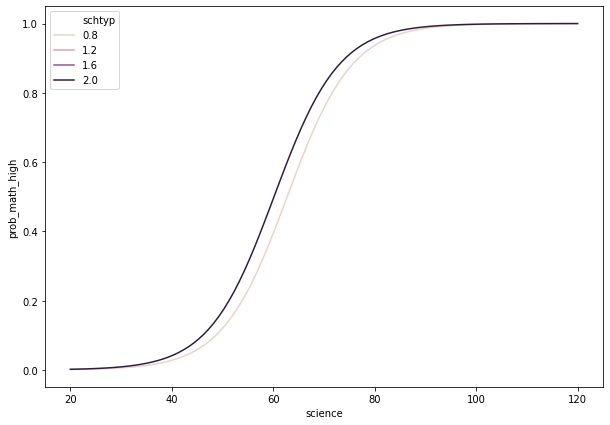

In [20]:
sns.lineplot('science', 'prob_math_high', data = sim_data, hue = 'schtyp')

The above predictions are what we call **soft predictions** because they are probabilities, as opposed to **hard predictions** which are `True, False` or `1, 0` predictions. To get the hard predictions, we first need to set a threshold $q \in (0, 1)$ and predict

$$
\begin{equation*}
\hat Y = \begin{cases}
             0  & \text{if } P(Y = 1) < q \\
             1  & \text{if } P(Y = 1) \ge q
     \end{cases} \quad
\end{equation*}
$$

Therefore hard predictions depend on the choice of the threshold $q$. All subsequent measures that are calculated from hard predictions (TP, TN, FP, FN, precision and recall, etc.) also depend on $q$.

- Use the model's `pred_table` method to get the **confusion matrix**. By default, this is based on $q = 0.50$ but change the value of $q$ to $0.30$. What is the precision and recall of this model?

- Calculate the sensitivity and specificity of the test. Sensitivity and specificity are two measures that are used to evaluate a binary classifier. We define **sensitivity** as $\frac{TP}{FN + TP}$ and **specificity** as $\frac{TN}{FP + TN}$.

We can see in the below cell the relationship between the $q$ and sensitivity or specificity.

In [ ]:
res = pd.DataFrame({'q': np.linspace(0, 1, num = 50)})
res['precision'] = 0
res['recall'] = 0
epsilon = 0.0001

for index, row in res.iterrows():
    cm = logit_model.pred_table(threshold = row['q'])
    res.loc[index, 'specificity'] = cm[0, 0] / (cm[0, :].sum() + epsilon)
    res.loc[index, 'sensitivity'] = cm[1, 1] / (cm[1, :].sum() + epsilon)

sns.lineplot('q', 'sensitivity', data = res, color = 'blue')
sns.lineplot('q', 'specificity', data = res, color = 'red')
plt.legend(['senstivity', 'specificity']);

- Explain why sensitivity drops as $q$ increases while specificity increases.

There are other ways to evaluate binary classification models, such as precision and recall. Sensitivity and specificity is more common in the medical field while precision and recall come from information retrieval. Recall and sensitivity have the same definition, but precision and specificity are not the same thing and should not be confused.

### End of exercise

## Summary

We learned how to extend linear regression for dealing with various situations. As you can see, linear regression gives us a very flexible building block. For this reason, many other algorithms build on the same ideas introduced in linear regression. We also saw how the coefficients in linear regression lend themselves to a simple interpretation, and how more complex models make this interpretation harder to maintain.